In [9]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
import yfinance as yf
from processing.downloader import DataDownloader

sns.set_style("whitegrid")

# 1. Inflation

Hypothesis: Some assets are better than others at protecting against inflation, i.e. they have a higher correlation with inflation.
Those assets could be: TIPS, Gold, Real Estate, Oil, Stocks, Bonds, etc.
We analyze the relationship between inflation and the assets mentioned above and create a portfolio that is optimized for inflation protection.


In [6]:
# Add the path to which you downloaded the data with the script
# Starting from the root of the git repo.
# For instance, if the repo had the structure
# .
# ├── .git
# ├── LICENSE
# ├── README.md
# ├── code
# ├── data                       < ---------- And you downloaded the data here
# │   └── prices.db
# ├── paper
# │   ├── paper.tex
# │   └── presentation.tex
# ├── pyproject.toml
# ├── requirements-dev.txt
# └── requirements.txt
#
# Set BASE_PATH = 'data'

BASE_PATH = 'data'
assert BASE_PATH != '<DATA_FOLDER>', "Don't forget to place the folder to which you downloaded the data, instead of placeholder"

In [7]:
import os.path

BASE_PATH = f'../../{BASE_PATH}'
db_file_name = 'prices.db'
db_file_path = os.path.join(BASE_PATH, db_file_name)
assert os.path.exists(db_file_path), f"The file {db_file_name} does not exist in {BASE_PATH}."

In [10]:
if __name__ == "__main__":
    data_dwder = DataDownloader(
        lst_tickers=[
            {
                "yahoo": "XHB"
            },  # Median Sale Price of Houses Sold in the United States
            {
                "fred": "CPIAUCSL"
            },  # Consumer Price Index for All Urban Consumers
            {
                "fred": "DCOILWTICO"
            },  # Crude Oil Prices: West Texas Intermediate (WTI)
            {"yahoo": "^GSPC"},  # S&P 500 Index
            {"yahoo": "GC=F"},  # Gold Futures
            {"fred": "GS10"},  # 10-Year Treasury Constant Maturity Rate
            {"fred": "GS30"},  # 30-Year Treasury Constant Maturity Rate
            {"yahoo": "VNQ"},  # REITs (Vanguard Real Estate ETF)
            {
                "yahoo": "DBC"
            },  # Commodities (Invesco DB Commodity Index Tracking Fund)
            {"yahoo": "FXE"},  # Foreign Currencies (CurrencyShares Euro Trust)
            {"yahoo": "BTC-USD"},  # Cryptocurrencies (Bitcoin)
            {
                "yahoo": "IGF"
            },  # Infrastructure Funds (iShares Global Infrastructure ETF)
            {"yahoo": "XLE"},  # Energy Stocks (Energy Select Sector SPDR Fund)
        ],
        concurrency=1,
        save=False,
        base_path=BASE_PATH,
    )
    data = data_dwder.load_data()
# Sort columns
data = data[sorted(data.columns)]
data = data.replace(0, np.nan)
data_cpy = data.copy()

2023-12-18 23:07:24,850 - DataDownloader - INFO - Folder for data already exists: ../../data


## 1.1 Data preparation

We will need the data in the following formats:
- Daily returns
- Yearly returns
- Yearly returns adjusted for inflation
- Daily returns adjusted for inflation
- Normalized yearly returns
- Normalized yearly returns adjusted for inflation

The first step to see any relationships between the assets is to plot them together and see if there is any visual correlation.
In this case we clearly see that GS10 and GS30 are very linked, makes sense since they are both treasury bonds.
But still, it's difficult to see any other relationships.

In [11]:
srs_cpi = np.log(data["CPIAUCSL"].dropna()).diff(365)
srs_cpi_dailylized = srs_cpi / 365

df_yearly_rets = np.log(data).diff(365)
df_yearly_rets_inflation_adjusted = df_yearly_rets.sub(srs_cpi, axis=0)

df_daily_rets = np.log(data.copy().drop("CPIAUCSL", axis=1)).diff()
df_daily_rets_inflation_adjusted = df_daily_rets.sub(
    srs_cpi_dailylized, axis=0
)

# Replace infs with NaNs
data = data.replace([np.inf, -np.inf], np.nan)

/home/ubuntu/dev/Markowitz-Portfolio-Optimisation/venv/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/home/ubuntu/dev/Markowitz-Portfolio-Optimisation/venv/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


# 2 Exploratory Data Analysis (EDA)

We will start by plotting the yearly returns of each asset and see if we can spot any relationships.
Since we are interested in inflation, we will also plot the yearly returns adjusted for inflation.
Our objective is to find assets that have a higher correlation with inflation. This means that when inflation goes up, the asset goes up as well.
One way to do this is to plot the yearly returns against the yearly inflation and see if there is any correlation, ie if the points are aligned in a straight line.
But since linear relationship might not take into account more complex relationships, we also plot the KDE estimates of the 2D distribution of the yearly returns and inflation.

We also look at the cointegration between pairs of assets, ie if they are cointegrated, ie if they are linked in the long term.




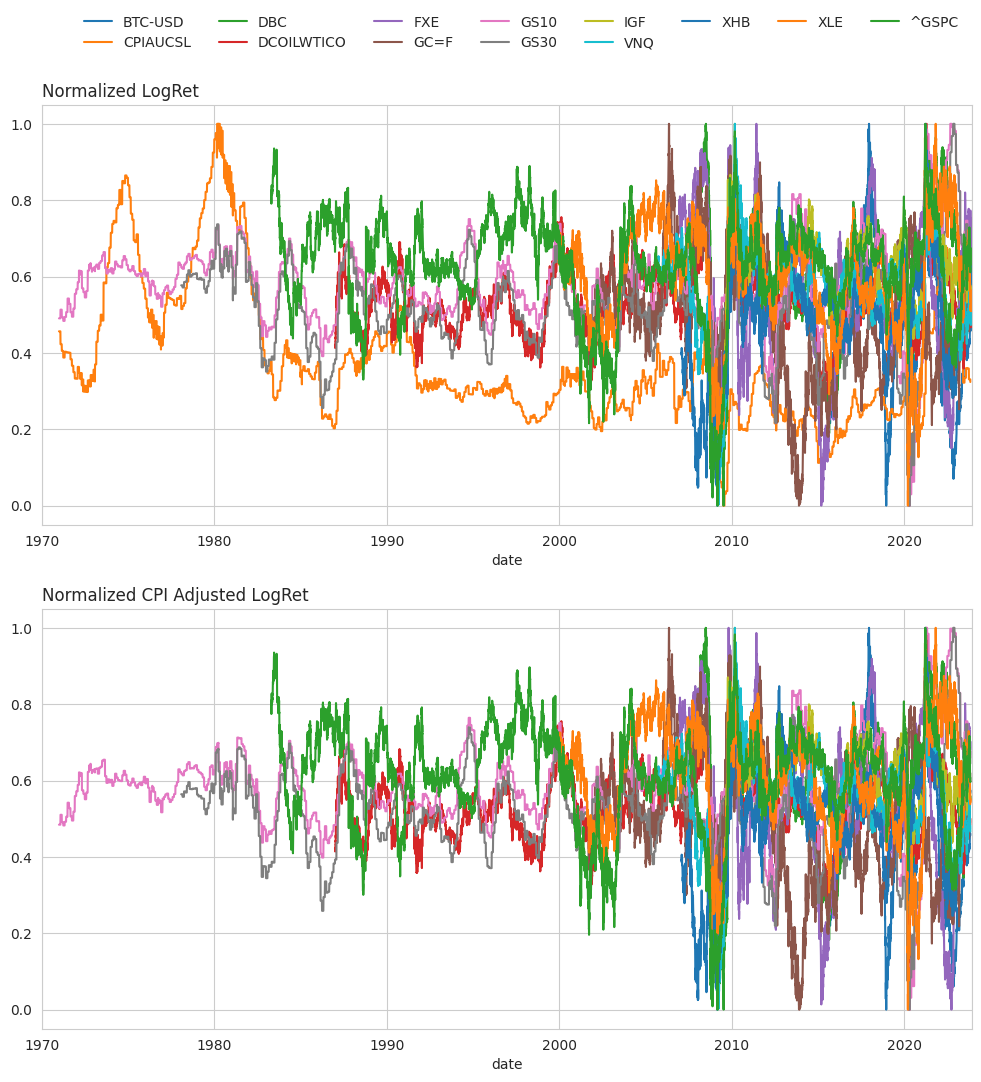

In [13]:
df_yearly_rets_norm = (df_yearly_rets - df_yearly_rets.min()) / (
    df_yearly_rets.max() - df_yearly_rets.min()
)
df_yearly_rets_inflation_adjusted_norm = (
    df_yearly_rets_inflation_adjusted - df_yearly_rets_inflation_adjusted.min()
) / (
    df_yearly_rets_inflation_adjusted.max()
    - df_yearly_rets_inflation_adjusted.min()
)

fig, axes = plt.subplots(2, 1, figsize=(12, 12))
for ax, data, title in zip(
    axes,
    [df_yearly_rets_norm, df_yearly_rets_inflation_adjusted_norm],
    ["Normalized LogRet", "Normalized CPI Adjusted LogRet"],
):
    data.plot(ax=ax, legend=False)
    ax.set_title(title, loc="left")
axes[0].legend(
    loc="lower right", ncol=8, frameon=False, bbox_to_anchor=(1, 1.1)
)

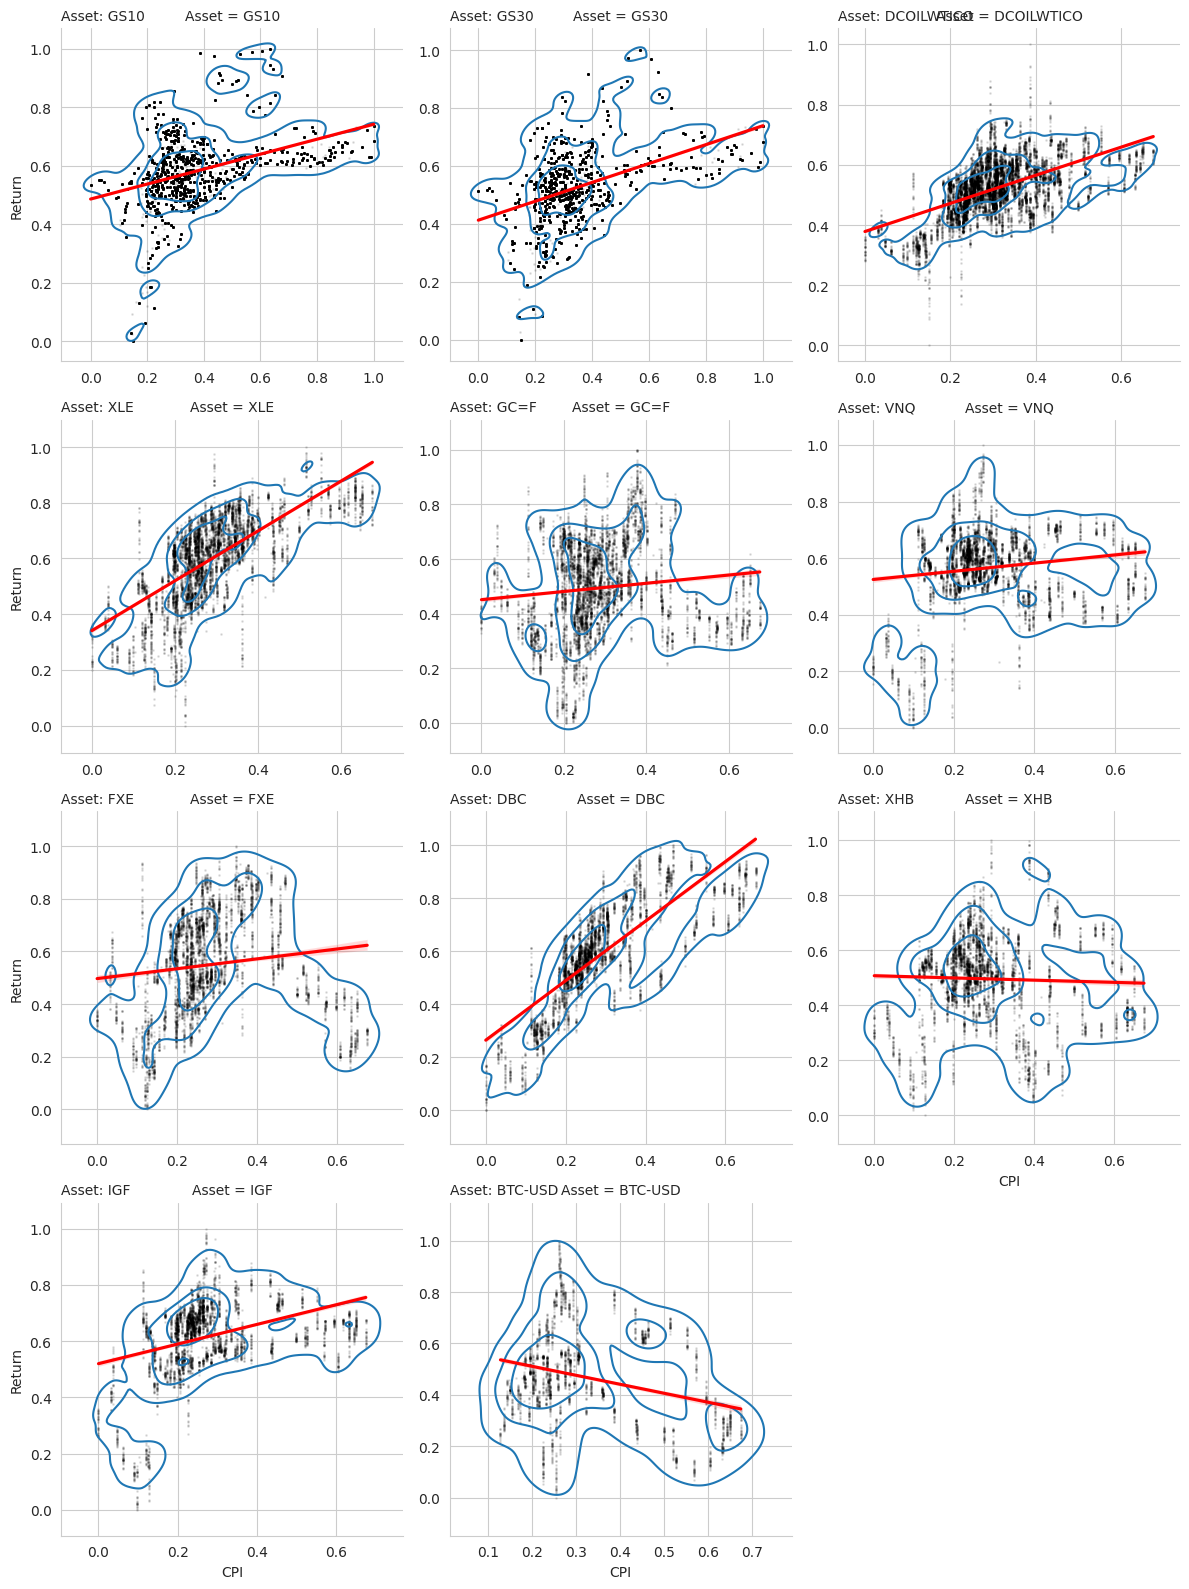

In [30]:
data_stck = (
    df_yearly_rets_norm.set_index("CPIAUCSL")
    .stack()
    .reset_index()
    .rename(columns={"ticker": "Asset", 0: "Return"})
    .dropna()
)
data_stck = data_stck[~data_stck["CPIAUCSL"].isna()].reset_index(drop=True)

# Define the number of columns for the grid
col_wrap = 3  # This can be adjusted as per your preference

# Create a FacetGrid
g = sns.FacetGrid(
    data_stck,
    col="Asset",
    col_wrap=col_wrap,
    height=4,
    sharex=False,
    sharey=False,
)

# Add the KDE plots and regression plots to each facet of the grid
g.map_dataframe(sns.kdeplot, x="CPIAUCSL", y="Return", levels=4)
g.map_dataframe(
    sns.regplot,
    x="CPIAUCSL",
    y="Return",
    scatter_kws={"s": 1, "color": "k", "alpha": 0.1},
    line_kws={"color": "r"},
)

# Set the titles and labels for each facet
g.set_titles("Asset: {col_name}", loc="left")
g.set_axis_labels("CPI", "Return")

In [ ]:
quantiles = data_stck["CPIAUCSL"].quantile(np.linspace(0, 1, 100))


def debug(x):
    x["CPIAUCSL"] = x["CPIAUCSL"].apply(
        lambda k: stats.percentileofscore(x["CPIAUCSL"], k)
    )
    x["Return"] = x["Return"].apply(
        lambda k: stats.percentileofscore(x["Return"], k)
    )
    return x


q_data = (
    data_stck.groupby("Asset").apply(lambda x: debug(x)).reset_index(drop=True)
)
g = sns.lmplot(
    data=q_data,
    x="CPIAUCSL",
    y="Return",
    hue="Asset",
    height=8,
    aspect=1.5,
    ci=None,
    legend=False,
    scatter=False,
    palette="tab10",
)

ax = g.axes[0, 0]
ax.set_title("Q-Q Plot per asset class", loc="left")
ax.plot(
    np.linspace(0, 100, 100),
    np.linspace(0, 100, 100),
    "k--",
    alpha=0.5,
    linewidth=1,
    label="Perfect Relationship",
)
ax.legend(
    loc="lower right",
    ncol=8,
    frameon=False,
    bbox_to_anchor=(1, 0.95),
    markerscale=10,
)
ax.set_xlabel("CPI Percentile")
ax.set_ylabel("Asset Return Percentile")

Text(0.5, 1.0, 'Correlation Matrix')

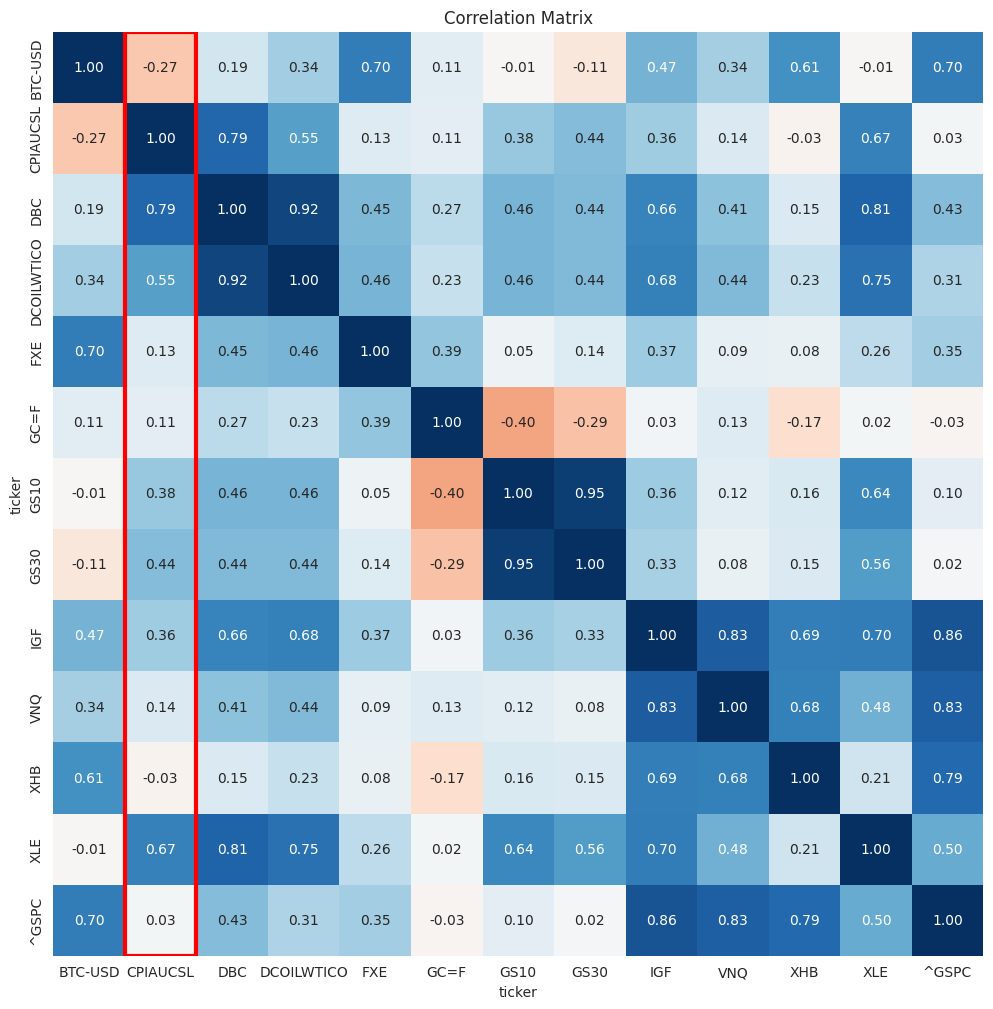

In [157]:
# Correlation matrix
corr = df_yearly_rets_norm.corr()
fig, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(
    corr,
    annot=True,
    vmin=-1,
    vmax=1,
    center=0,
    fmt=".2f",
    cbar=False,
    cmap="RdBu",
)


n = len(corr)
idx_cpi = corr.index.get_loc("CPIAUCSL")
ax.add_patch(
    plt.Rectangle((idx_cpi, 0), 1, n, fill=False, edgecolor="red", lw=3)
)
ax.set_title("Correlation Matrix")

Text(0.5, 1.0, 'Correlation Matrix')

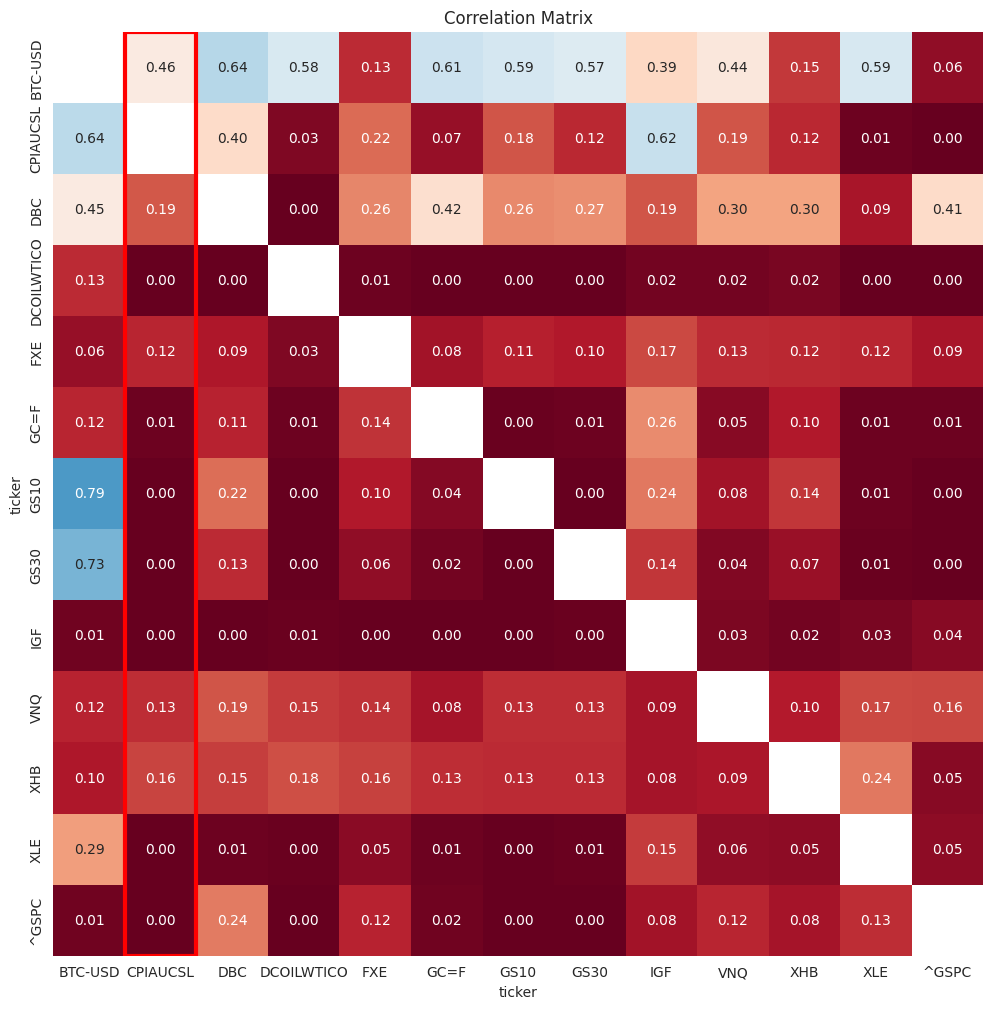

In [41]:
# Compute pairwise cointegration for all assets

import statsmodels.tsa.stattools as ts

coint = pd.DataFrame(
    index=df_yearly_rets_norm.columns, columns=df_yearly_rets_norm.columns
)
for i in df_yearly_rets_norm.columns:
    for j in df_yearly_rets_norm.columns:
        if i != j:
            data_dna = df_yearly_rets_norm[[i, j]].dropna()
            coint.loc[i, j] = ts.coint(data_dna[i], data_dna[j])[1]
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    coint.astype(float),
    annot=True,
    vmin=0,
    vmax=1,
    center=0.5,
    fmt=".2f",
    cbar=False,
    cmap="RdBu",
)
ax.set_title("Cointegration Matrix")
ax.grid(False)

n = len(corr)
idx_cpi = corr.index.get_loc("CPIAUCSL")
ax.add_patch(
    plt.Rectangle((idx_cpi, 0), 1, n, fill=False, edgecolor="red", lw=3)
)
ax.set_title("Correlation Matrix")

# 3. Portfolio Optimization

We will use the following assets:
- GS10: 10-Year Treasury Constant Maturity Rate
- GS30: 30-Year Treasury Constant Maturity Rate
- DCOILWTICO: Crude Oil Prices: West Texas Intermediate (WTI)
- XLE: Energy Stocks (Energy Select Sector SPDR Fund)
- GC=F: Gold Futures
- FXE: Foreign Currencies (CurrencyShares Euro Trust)
- DBC: Commodities (Invesco DB Commodity Index Tracking Fund)
- BTC-USD: Cryptocurrencies (Bitcoin)

We will create a portfolio that is optimized for inflation protection.
For this reason we will use the daily returns adjusted for inflation as the input for the optimization.
We will use the Sharpe Ratio as the metric to optimize for, we try to maximize the Sharpe Ratio while keeping the volatility low.
Some bounds for the weights are also set, we don't want to have too much weight in a single asset, so we set the minimum and maximum weight to 5% and 30% respectively in order to ensure some diversification.

We also create a portfolio that is equally weighted, this will be our benchmark.

In [158]:
from scipy.optimize import minimize


df_rets_portfolio = df_daily_rets_inflation_adjusted[
    ["GS10", "GS30", "DCOILWTICO", "XLE", "GC=F", "FXE", "DBC", "BTC-USD"]
]
n_assets = len(df_rets_portfolio.columns)

mean_returns = df_rets_portfolio.mean()
cov_matrix = df_rets_portfolio.cov()


# Function to calculate portfolio performance metrics
def portfolio_performance(weights, mean_returns, covariance):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(covariance, weights))) * np.sqrt(
        252
    )
    sharpe_ratio = returns / std
    return std, returns, sharpe_ratio


# Function to minimize (negative Sharpe Ratio)
def negative_sharpe(weights, mean_returns, covariance):
    return -portfolio_performance(weights, mean_returns, covariance)[2]


# Constraints (weights sum to 1)
constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}

# Boundaries for weights
bounds = tuple((0.05, 0.3) for asset in range(n_assets))

# Initial guess (equal distribution)
initial_guess = n_assets * [
    1.0 / n_assets,
]

# Optimization
opt_results = minimize(
    negative_sharpe,
    initial_guess,
    args=(mean_returns, cov_matrix),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
)

# Optimal weights
optimal_weights = opt_results.x

# Optimal performance metrics
(
    portfolio_std_dev,
    portfolio_return,
    portfolio_sharpe_ratio,
) = portfolio_performance(optimal_weights, mean_returns, cov_matrix)

# Print the results
print("Optimal weights:", optimal_weights)
print("Expected annual return:", portfolio_return)
print("Annual volatility / std dev:", portfolio_std_dev)
print("Sharpe Ratio:", portfolio_sharpe_ratio)

Optimal weights: [0.05 0.05 0.05 0.15 0.3  0.05 0.05 0.3 ]
Expected annual return: 0.09822469115526966
Annual volatility / std dev: 0.19955548976681955
Sharpe Ratio: 0.49221743420862607


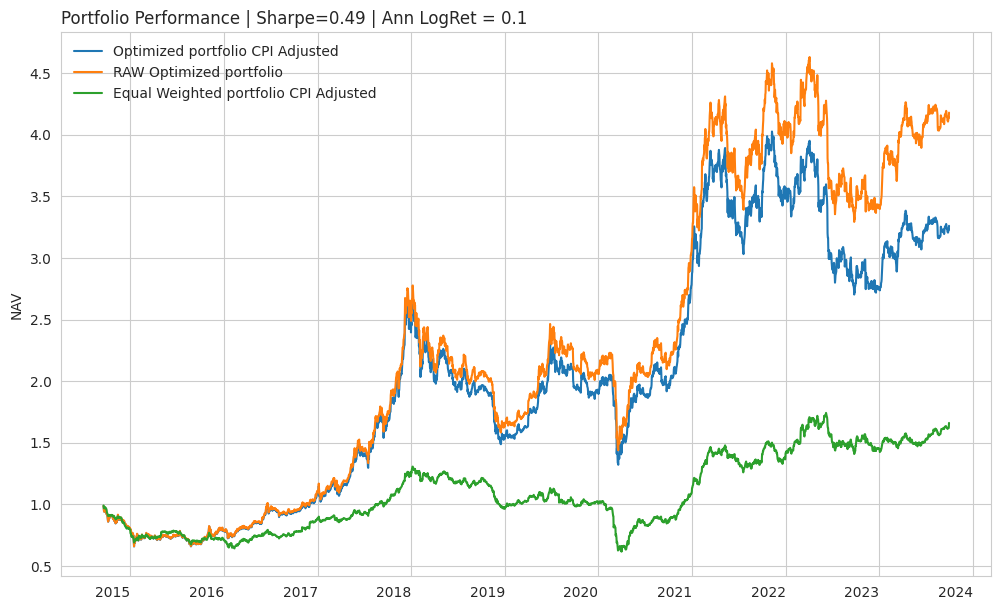

In [159]:
fig, ax = plt.subplots(figsize=(12, 8))
np.exp(
    (df_rets_portfolio * optimal_weights).dropna().sum(axis=1)
).cumprod().plot(label="Optimized portfolio CPI Adjusted")

np.exp(
    ((df_rets_portfolio.add(srs_cpi_dailylized, axis=0)) * optimal_weights)
    .dropna()
    .sum(axis=1)
).cumprod().plot(label="RAW Optimized portfolio")

np.exp(
    (df_rets_portfolio * ([1 / n_assets] * n_assets)).dropna().sum(axis=1)
).cumprod().plot(label="Equal Weighted portfolio CPI Adjusted")


ax.legend(loc="upper left", frameon=False)
ax.set_title(
    f"Portfolio Performance | Sharpe={round(portfolio_sharpe_ratio,2)} | Ann LogRet = {round(portfolio_return,2)}",
    loc="left",
)
ax.set_ylabel("NAV")
ax.set_xlabel("")
ax.tick_params(axis="x", rotation=0)

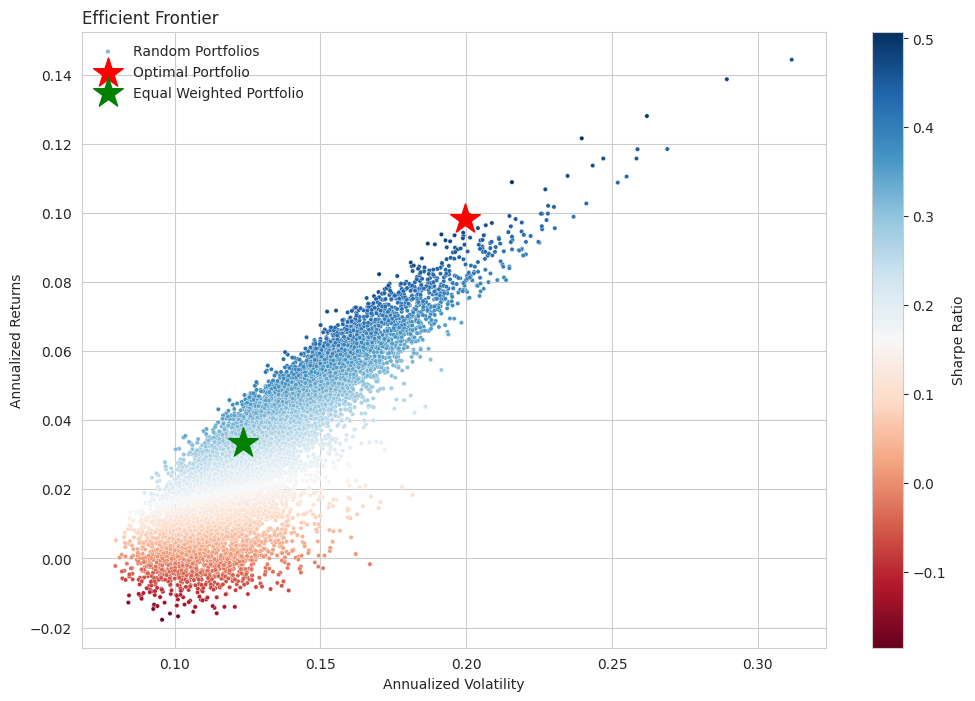

In [160]:
means = []
stds = []
sharpe = []
fig, ax = plt.subplots(figsize=(12, 8))
for i in range(10000):
    weights = np.random.random(n_assets)
    weights /= np.sum(weights)
    means.append(np.sum(mean_returns * weights) * 252)
    stds.append(
        np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    )
    sharpe.append(means[-1] / stds[-1])

norm = plt.Normalize(min(sharpe), max(sharpe))
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])
sns.scatterplot(
    x=stds,
    y=means,
    c=sharpe,
    ax=ax,
    label="Random Portfolios",
    cmap="RdBu",
    marker="o",
    s=10,
)

# Set plot titles and labels
ax.set_title("Efficient Frontier", loc="left")
ax.set_xlabel("Annualized Volatility")
ax.set_ylabel("Annualized Returns")
ax.tick_params(axis="x", rotation=0)
plt.colorbar(sm, ax=ax, orientation="vertical", label="Sharpe Ratio")

ax.scatter(
    portfolio_std_dev,
    portfolio_return,
    marker="*",
    color="r",
    s=500,
    label="Optimal Portfolio",
)

ax.scatter(
    np.sqrt(
        np.dot(
            ([1 / n_assets] * n_assets),
            np.dot(cov_matrix, ([1 / n_assets] * n_assets)),
        )
    )
    * np.sqrt(252),
    np.sum(mean_returns * ([1 / n_assets] * n_assets)) * 252,
    marker="*",
    color="g",
    s=500,
    label="Equal Weighted Portfolio",
)

ax.legend(loc="upper left", frameon=False)